In [64]:
import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# %load ../src/weather_data_clean.py
import pandas as pd

def clean_weather_data(filename):
    """Take ASOS weather data file for Stampede pass and clean it ready for input to model.
    Input: txt file
    Output: pandas dataframe
    """
    data = pd.read_csv(filename)

    # Rename two of the columns
    data.rename(columns={'valid':'date', 'tmpf':'temp'}, inplace=True)

    # Remove the few rows that have a null value for temp
    data = data[~data.temp.eq('M')]

    # Remove spaces from column names
    data.rename(columns=lambda x: x.replace(' ', ''), inplace=True)

    # Only use the standard hourly weather reading at 56 mins past each hour
    mask = data['date'].apply(lambda x: x[-2:] == '56')
    data = data[mask]

    # Create a date series to be used in the clean dataframe
    date = pd.to_datetime(data['date'])

    # Create a temp series to be used in the clean dataframe
    temp = data['temp'].apply(float)

    # Cast the null value M to zero to enable create of the raw precipitation series cast to floats
    data.p01i[data.p01i == 'M'] = 0
    raw_precipitation = data['p01i'].apply(float)

    # Create a precipitation series to be used in the clean dataframe
    precipitation = raw_precipitation.apply(lambda x: True if (x > 0) else False)

    # Convert sky coverage data to clear or cloudy and create an overcast series to be used in the clean dataframe
    sky_elements = ['skyc1', 'skyc2', 'skyc3']
    data.skyc1 = data.skyc1.astype(str)
    data.skyc2 = data.skyc2.astype(str)
    data.skyc3 = data.skyc3.astype(str)
    sky_agg = data[sky_elements].values.tolist()
    sky_reduce = [['overcast' if (('BKN' in element) or ('OVC' in element) or ('VV' in element)) else 'clear'
                    for element in row] for row in sky_agg]
    overcast = pd.Series([True if 'overcast' in row else False for row in sky_reduce])
    overcast.index = date.index

    # Cast the null value 'M' to 10.00 to enable the creation of a poor visibility series
    data.vsby[data.vsby == 'M'] = 10.00
    raw_visibility = data['vsby'].apply(float)
    poor_visibility = pd.Series([True if value < 0.50 else False for value in raw_visibility])
    poor_visibility.index = date.index

    # Cast the null value 'M' to 0 to enable the creation of a windy series
    data.sknt[data.sknt == 'M'] = 0.00
    data.gust[data.gust == 'M'] = 0.00
    wind_speed = data['sknt'].apply(float)
    gust_speed = data['gust'].apply(float)
    wind_df = pd.concat([wind_speed, gust_speed], axis=1)
    # Finally apply the function f to enable the creation of the windy column
    windy = wind_df.apply(f, axis=1)

    """Create the cleaned dataframe by concatenating the date, temp, precipitation, overcast, poor_visibility
    and windy series"""
    df = pd.concat([date, temp, precipitation, overcast, poor_visibility, windy], axis=1)
    df.columns = ['date', 'temp', 'precipitation', 'overcast', 'poor_visibility', 'windy']
    cleaned_df = df[(df['date'] > '2006-12-31') & (df['date'] < '2018-04-03')]
    return cleaned_df

def f(row):
    """Function to be able to create the windy series with windy being true if wind speed is above 10 knots
    or gust speed is above 20 knots"""
    if row['sknt'] >= 10.00:
        val = True
    elif row['gust'] >= 20.00:
        val = True
    else:
        val = False
    return val




In [4]:
weather_df = clean_weather_data('ASOS_stampede_pass/SMP-2.txt')

/Users/leanne/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
# %load ../src/pass_data_clean.py
import pandas as pd

def clean_pass_data(filename):
    """Take Snoqualmie pass closure data file and clean it ready for input to model.
    Input: xlsx file
    Output: Pandas dataframe
    """
    data = pd.read_excel(filename, header=[1])

    #drop unnamed/unnecessary columns
    data.drop(data.columns[[11,12,13,14]], axis=1, inplace=True)

    #drop unnecessary secondary incident columns
    data.drop(data.columns[[1,8]], axis=1, inplace=True)

    #rename 'Incident...' columns to start_time and end_time 
    data.rename(columns={'INCIDENT START TIMES FOR EACH DIRECTION':'start_time'}, inplace=True)
    data.rename(columns={'INCIDENT END TIMES - DIRECTIONAL':'end_time'}, inplace=True)

    #use only dates from 2007-01-01 to match with available weather and traffic volume data
    df = data[(data['start_time'] > '2006-12-31')]

    #rename 'Delay Time Total' to delay
    df.rename(columns={'Delay Time Total':'delay'}, inplace=True)

    #drop row with nan value in delay
    df = df.dropna(subset=['delay'])

    #create a westbound pandas series with True if westbound and false if eastbound
    westbound = pd.Series([True if value == 'WB' else False for value in df.DIRECTION])

    #create a snow pandas series with True if weather description contains sn, false otherwise
    snow = df.WEATHER.str.contains('sn', case=False, na=False, regex=True)

    #create pandas series for start and end times
    start_time = pd.to_datetime(df['start_time'])
    end_time = pd.to_datetime(df['end_time'])

    #ensure that all the pandas series created have the same index
    westbound.index = start_time.index
    snow.index = start_time.index
    end_time.index = start_time.index

    #create cleaned df with the series created
    cleaned_df = pd.concat([start_time, end_time, westbound, snow], axis=1)

    #rename columns
    cleaned_df.rename(columns={0:'westbound', 'WEATHER':'snow'}, inplace=True)

    return cleaned_df



In [9]:
# %load ../src/combine_data.py

pass_closure_df = clean_pass_data('Cumulative_Snoqualmie_Pass_Delay_Closures_1992_2018.xlsx')

def get_pass_closure(date_time):
    """take a date_time and check if it is between the start and end times of a closure event
    input: datetime
    output: boolean
    """
    start_end_times = list(zip(pass_closure_df.start_time, pass_closure_df.end_time))
    for row in start_end_times:
        if row[0] <= date_time <= row[1]:
            return True
    return False

def add_pass_closed(df):
    """take the weather df and add a new column for whether or not the pass is closed at each date_time
    input: pandas dataframe
    output:pandas dataframe
    """
    df['pass_closed'] = df['date'].map(get_pass_closure)
    return df

/Users/leanne/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [10]:
combined_df = add_pass_closed(weather_df)

In [11]:
combined_df.index = combined_df.date

In [61]:
combined_df

,date,temp,precipitation,overcast,poor_visibility,windy,pass_closed
date,,,,,,,
2006-12-31 23:56:00,2006-12-31 23:56:00,23.00,False,True,False,False,False
2007-01-01 00:56:00,2007-01-01 00:56:00,26.06,False,False,False,False,False
2007-01-01 01:56:00,2007-01-01 01:56:00,24.98,False,False,False,False,False
2007-01-01 02:56:00,2007-01-01 02:56:00,24.08,False,False,False,False,False
2007-01-01 03:56:00,2007-01-01 03:56:00,24.08,False,False,False,False,False
2007-01-01 05:56:00,2007-01-01 05:56:00,19.94,False,True,True,False,False
2007-01-01 10:56:00,2007-01-01 10:56:00,19.94,True,True,False,False,False
2007-01-01 11:56:00,2007-01-01 11:56:00,19.04,True,True,False,False,False
2007-01-01 12:56:00,2007-01-01 12:56:00,19.94,True,True,False,False,False


In [12]:
daily_df = combined_df.resample("D").agg({'temp':'mean','precipitation':'max', 'overcast':'max', 'poor_visibility':'max', 'windy':'max', 'pass_closed':'max'})

In [13]:
daily_df.dropna(inplace=True)

In [62]:
daily_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed
date,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0


In [68]:
X_train, X_test, y_train, y_test = train_test_split(daily_df.drop('pass_closed',axis=1), 
                                                    daily_df['pass_closed'], test_size=0.30, 
                                                    random_state=101)

In [69]:
logmodel = LogisticRegression()

In [70]:
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [71]:
probs = logmodel.predict_proba(X_test)

In [72]:
probs

array([[0.78983845, 0.21016155],
       [0.85199739, 0.14800261],
       [0.89424573, 0.10575427],
       ...,
       [0.91618622, 0.08381378],
       [0.91460226, 0.08539774],
       [0.92984509, 0.07015491]])

In [73]:
probs[:,1].max()

0.3694426270973859

In [74]:
probs[:,1].min()

0.022531650755139018

In [75]:
probs[:,1].mean()

0.10423754443303634

In [76]:
model_log_loss = log_loss(y_test, probs)

In [77]:
model_log_loss

0.33518362780167477

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])

In [79]:
roc_auc = auc(fpr, tpr)

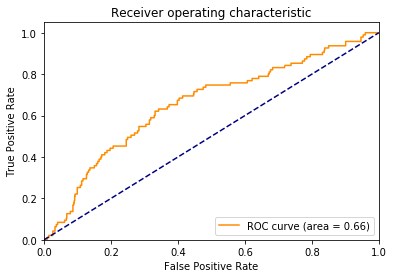

In [80]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
daily2_df = daily_df.copy()

In [27]:
daily2_df['month'] = daily2_df.index.month

In [28]:
daily2_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,month
date,,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0,12
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0,1
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0,1
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0,1
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0,1
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0,1
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0,1
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0,1
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0,1


In [29]:
daily2_df['dayofweek'] = daily2_df.index.dayofweek

In [30]:
daily2_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,month,dayofweek
date,,,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0,12,6
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0,1,0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0,1,1
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0,1,2
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0,1,3
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0,1,4
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0,1,5
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0,1,6
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0,1,0


In [81]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(daily2_df.drop('pass_closed',axis=1), 
                                                    daily2_df['pass_closed'], test_size=0.30, 
                                                    random_state=101)

In [82]:
logmodel2 = LogisticRegression()

In [83]:
logmodel2.fit(X_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [84]:
probs2 = logmodel2.predict_proba(X_test2)

In [85]:
probs2[:,1].max()

0.36601355951515424

In [86]:
probs2[:,1].min()

0.022785149750551698

In [87]:
probs2[:,1].mean()

0.10435970517560472

In [88]:
model2_log_loss = log_loss(y_test, probs2)

In [89]:
model2_log_loss

0.33536872022640535

In [90]:
fpr2, tpr2, thresholds2 = roc_curve(y_test2, probs2[:,1])

In [92]:
roc_auc2 = auc(fpr2, tpr2)

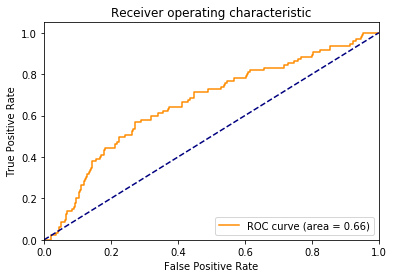

In [93]:
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [41]:
summer_months = [5,6,7,8,9,10]
daily3_df = daily2_df[~daily2_df.month.isin(summer_months)]

In [42]:
daily3_df

,temp,precipitation,overcast,poor_visibility,windy,pass_closed,month,dayofweek
date,,,,,,,,
2006-12-31,23.000000,0.0,1.0,0.0,0.0,0.0,12,6
2007-01-01,28.253750,1.0,1.0,1.0,1.0,0.0,1,0
2007-01-02,41.735000,1.0,1.0,1.0,1.0,1.0,1,1
2007-01-03,32.993913,1.0,1.0,1.0,1.0,0.0,1,2
2007-01-04,26.682500,1.0,1.0,1.0,1.0,0.0,1,3
2007-01-05,32.030000,1.0,1.0,1.0,1.0,0.0,1,4
2007-01-06,28.385000,1.0,1.0,0.0,1.0,1.0,1,5
2007-01-07,34.310000,1.0,1.0,1.0,1.0,1.0,1,6
2007-01-08,32.922500,1.0,1.0,1.0,1.0,0.0,1,0


In [43]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(daily3_df.drop('pass_closed',axis=1), 
                                                    daily3_df['pass_closed'], test_size=0.30, 
                                                    random_state=101)

In [44]:
logmodel3 = LogisticRegression()

In [45]:
logmodel3.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
probs3 = logmodel3.predict_proba(X_test3)

In [55]:
probs3

array([[0.88772554, 0.11227446],
       [0.89081253, 0.10918747],
       [0.90832815, 0.09167185],
       [0.89416515, 0.10583485],
       [0.80433238, 0.19566762],
       [0.91039959, 0.08960041],
       [0.89102955, 0.10897045],
       [0.80741977, 0.19258023],
       [0.8984721 , 0.1015279 ],
       [0.83918538, 0.16081462],
       [0.94235257, 0.05764743],
       [0.82755367, 0.17244633],
       [0.90447664, 0.09552336],
       [0.86342592, 0.13657408],
       [0.90815396, 0.09184604],
       [0.87660233, 0.12339767],
       [0.82240355, 0.17759645],
       [0.84126209, 0.15873791],
       [0.89183903, 0.10816097],
       [0.80515765, 0.19484235],
       [0.749246  , 0.250754  ],
       [0.84241272, 0.15758728],
       [0.84304761, 0.15695239],
       [0.89040588, 0.10959412],
       [0.89668486, 0.10331514],
       [0.84973451, 0.15026549],
       [0.88065816, 0.11934184],
       [0.8445087 , 0.1554913 ],
       [0.85896194, 0.14103806],
       [0.89203981, 0.10796019],
       [0.

In [56]:
probs3[:,1].max()

0.3334329148329053

In [57]:
probs3[:,1].min()

0.03718611548686593

In [58]:
probs3[:,1].mean()

0.12537773063696017

In [59]:
model3_log_loss = log_loss(y_test3, probs3)

In [60]:
model3_log_loss

0.4488394260594539

In [94]:
fpr3, tpr3, thresholds3 = roc_curve(y_test3, probs3[:,1])

In [95]:
roc_auc3 = auc(fpr3, tpr3)

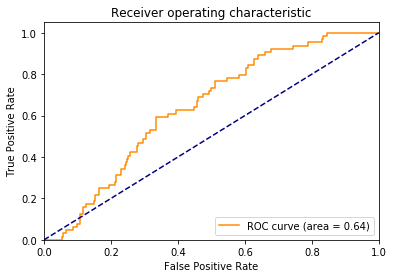

In [96]:
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc3)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()